# Assignment 2: CRF sequence tagging for Move Queries

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In tha above cell all the necessary libraries are imported and I have imported test_train_split from sklearn.model_selection for splitting the training data into 80% training data and remaining 20% data as Development data.

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

Here we have loaded the engtrain.bio.txt data in raw_training_data.

# ANSWER 1

In [4]:
train_data, development_data = train_test_split(raw_training_data, train_size=0.8, shuffle = False)

Here we have splitted the data into 80% training data and 20% development data with the help of sklearn and shuffle value is passed as false.

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [6]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

9775 instances
99491 words


The length of training data is calculated with the len method and is 9775 instances and 99491 words in the training data.

In [7]:
print(len(train_data), 'instances')
print(sum([len(sent) for sent in train_data]), "words")

7820 instances
79266 words


In [8]:
print(len(development_data), 'instances')
print(sum([len(sent) for sent in development_data]), "words")

1955 instances
20225 words


The number of instances in training and development data are 7820 and 1955 respectively and number of words in training and development data are 79266 and 20225 respectively.

In [9]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

This is the preprocess function which will have no change for first three questions.

In [10]:
training_data = [preProcess(example) for example in raw_training_data]

In [11]:
# check the effect of pre-processing
print(training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [12]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

This is the get_feature function

In [13]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


The Bio tagger above is trained with the training data.

In [14]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


Here the tagger is loaded and test data is prepared and is tested in the below cell.

In [15]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [16]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))

                   precision    recall  f1-score   support

          B-ACTOR       0.76      0.88      0.81       812
      B-CHARACTER       0.72      0.26      0.38        90
       B-DIRECTOR       0.77      0.61      0.68       456
          B-GENRE       0.91      0.95      0.93      1117
           B-PLOT       0.60      0.40      0.48       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.87      0.82      0.84       451
         B-REVIEW       0.14      0.02      0.03        56
           B-SONG       0.69      0.17      0.27        54
          B-TITLE       0.58      0.50      0.54       562
        B-TRAILER       0.80      0.80      0.80        30
           B-YEAR       0.94      0.94      0.94       720
          I-ACTOR       0.75      0.89      0.81       862
      I-CHARACTER       0.76      0.29      0.42        75
       I-DIRECTOR       0.78      0.60      0.68       496
          I-GENRE       0.84      0.71      0.77       

c:\users\rohit\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This is the classification report of the test data with macro avg precision of 0.67

In [17]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

This is a function of confusion_matrix_heatmap to plot the confusion matrix.

c:\users\rohit\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['B-REVIEW', 'I-YEAR', 'I-RATING', 'I-TITLE', 'B-DIRECTOR', 'B-RATING', 'I-GENRE', 'I-RATINGS_AVERAGE', 'I-REVIEW', 'B-GENRE', 'B-PLOT', 'B-CHARACTER', 'I-PLOT', 'B-ACTOR', 'O', 'I-SONG', 'B-TRAILER', 'B-TITLE', 'I-CHARACTER', 'I-TRAILER', 'B-RATINGS_AVERAGE', 'B-YEAR', 'B-SONG', 'I-ACTOR', 'I-DIRECTOR'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


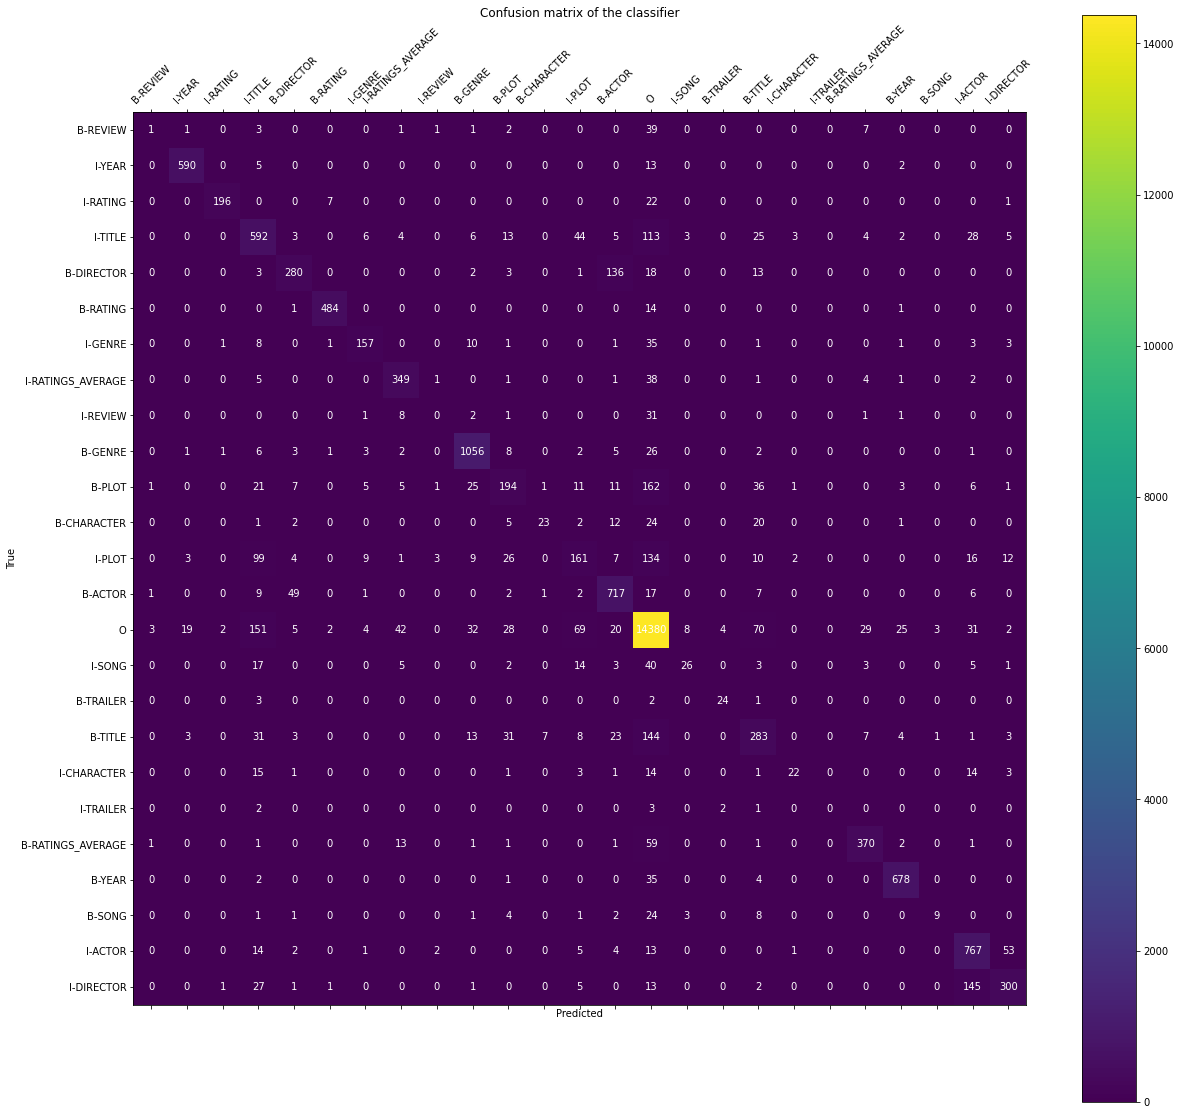

In [18]:
confusion_matrix_heatmap(y_test, preds)

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


# 2. Error analysis 1: False positives (10 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


In [19]:
train_data1 = [preProcess(example) for example in train_data]

In [20]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu_develop.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_data1, TAGGER_PATH)
print("done")

training tagger...
done


Here we have changed the tagger file for the 2nd Question and the tagger is trained on the training data.

In [21]:
development_data1 = [preProcess(example) for example in development_data]

In [22]:
print("testing tagger...")
preds1 = []
y_test1 = []
for sent in development_data1:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds1.extend(sent_preds)
    y_test1.extend(sent_true)
print("done")

testing tagger...
done


Here we have tested the tagger on the preprocessed development data.

In [23]:
print(classification_report(y_test1, preds1))

                   precision    recall  f1-score   support

          B-ACTOR       0.65      0.87      0.74       433
      B-CHARACTER       0.70      0.32      0.44        44
       B-DIRECTOR       0.76      0.63      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.48      0.43      0.45       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.88      0.88       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.50      0.25      0.33        20
          B-TITLE       0.66      0.35      0.46       679
        B-TRAILER       1.00      0.50      0.67        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.66      0.85      0.74       482
      I-CHARACTER       0.58      0.60      0.59        47
       I-DIRECTOR       0.76      0.62      0.69       410
          I-GENRE       0.90      1.00      0.95       

This is the classification report of the development data and from here we have to select the the lowest five precision of the classes which are B-REVIEW, I-REVIEW, I-TRAILER, I-PLOT, I-SONG. And for third Question we have to select the lowest five recall classes which are B-REVIEW, I-REVIEW, I-TRAILER, B-SONG, I-SONG.

In [24]:
print("testing tagger...")
preds2 = []
y_test2 = []
SENT = []
low5_labels= ['I-TRAILER', 'I-REVIEW', 'B-REVIEW', 'I-PLOT', 'I-SONG']
for sent in development_data1:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds2.extend(sent_preds)
    y_test2.extend(sent_true)
    for labels in low5_labels:
        for i in range(len(sent_preds)):
            if sent_preds[i] == labels and sent_preds[i] != sent_true[i]:
                s = ''
                for j in sent:
                    s = s+ j[0] + ' '
                if s not in SENT:
                    SENT.append(s)
                    print(s)
print("done")

testing tagger...
what genre is the movie my date with the presidents daughter 
what is becoming jesse tate 
what is forbidden love about 
what is internal affairs 
what is such hawks such hounds about 
what is trading places 
what is a pg 13 rated drama movie made in the 1990 s that concerns health issues 
what is a excellent rated 1970 s drama involving mental abilities 
what is a family movie with actor bobbie phillips 
what is a funny high school movie that is well rated 
what is a good movie based on war involving war crimes 
what is a good romantic drama i can take my wife to see 
what is a movie about a party whose ratings averaged about a nine 
what is a movie in the past nine decades about a journey with jonathan taylor thomas that includes jokes 
what is a movie where nicholas lea plays a lieutenant general 
what is a nine star rated movie that is rated nc 17 and involves drugs 
what is a rated r documentary directed by thomas l phillips 
what is a rated r movie directed by c

Here we have passed five labels with lowest precisions in the list low5_labels. Then we have test the tagger on the development set and passed the False Negatives of the five selected class. For that used for loops. 

First For loop is for sentences in development_data and Second For loop is for labels in the low5_labels list and third loop is in the range of length of the sent_preds after that we have added the space between the words and then we have appended it to the SENT list and then we have printed that.
The above sentences are the False Positives in the 5 classes with lowest precision.

# 3. Error analysis 2: False negatives (10 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


In [25]:
print("testing tagger...")
preds22 = []
y_test22 = []
SENT = []
low5_labels= ['I-TRAILER', 'I-REVIEW', 'B-REVIEW', 'I-SONG', 'B-SONG']
for sent in development_data1:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds22.extend(sent_preds)
    y_test22.extend(sent_true)
    for labels in low5_labels:
        for i in range(len(sent_preds)):
            if sent_preds[i] == labels and sent_preds[i] != sent_true[i]:
                s = ''
                for j in sent:
                    s = s+ j[0] + ' '
                if s not in SENT:
                    SENT.append(s)
                    print(s)
print("done")

testing tagger...
what is expected to be the best action movie of the year 
what is the best action movie from the last nine decades staring mark harmon with a pg 13 rating 
what is the best action movie of the 1990 s 
what is the best action movie that denzel washington is in 
what is the best action movie this year 
what is the best child movie by kelly overton that was made in the past decade 
what is the best comedy of the 1970 s 
what is the best comedy that came out in 2011 
what is the best crime movie from 2010 
what is the best drama that robert redford was ever in 
what is the best drama that came out in the 2000 s 
what is the best fantasy movie of all time 
what is the best military movie of all time 
what is the best psychological drama that was made in the 1950 s 
what is the best romantic comedy that came out in 2011 
what is the best sci fi film of 1950 
what is the best sci fi movie of the 2010 s 
what is the best science fiction movie directed by george lucas 
what is

Here I have again selected 5 classes with lowest recall and passed the for loops again and checked with the if condition that it satisfies  the condition of false negatives.

The above sentences are the False negatives of the 5 classes with lowest recalls.

# 4. Using POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [26]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


# 5. Feature experimentation for optimal macro average (20 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format. You could try more suffixes/prefixes of the curret word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q1 and Q2 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes. Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `engtest.bio.txt`) as your final piece of code.